Author: 
* Daniel Huang

* Rishabh Chittaranjan (For the BCIDataset Class)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch torchvision mat73 pymatreader matplotlib tensorboard mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 33.1 MB/s 


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# BCIDataset: Python Class for Loading S1,S2,S3 Zip files and Data Processing Methods (Developed by Rishab)

In [ ]:
datasetdir = "/content/gdrive/MyDrive/BCI_Project/Datasets"
import scipy.io as scipy
import string
import os
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import zipfile
import io
from zipfile import ZipFile
import numpy as np
import mat73
import mne.filter as MNE_Filter
import mne.io as MNE_Io
from enum import Enum
import matplotlib.pyplot as plt
import random

class DatasetType(Enum):
  TRAIN = 0
  VALIDATION = 1
  TEST = 2

def find_key(diction, key_tag):
  for key in diction:
      if key_tag in key:
        return key
  return "WaveData" 

def calc_frequency(old_points, new_points,orig_frequency):
  total_time = old_points/orig_frequency
  new_freq = (new_points/total_time)

  if(old_points > new_points):
      return orig_frequency / new_freq, new_freq
  else:
    return new_freq/orig_frequency, new_freq

def split_sample(X,y,type):
  sample_len,target_len = X.size(0),y.size(0)
  assert sample_len == target_len
  proportions = [0.8,0.1,0.2]
  index_range = [0]
  for i in proportions:
    index_range.append(index_range[-1] + int(sample_len * i))
  index_range[-1] = sample_len
  return X[index_range[type.value]:index_range[type.value+1]].float(), y[index_range[type.value]:index_range[type.value+1]].float()


def batching_data(sample, target, batch_size):
  assert len(sample) == len(target) # assume received a list of data
  list_of_samp_splits = []
  list_of_targ_splits = []
  for sequence in range(len(sample)):
    list_of_samp_splits.append(list(torch.split(sample[sequence],batch_size)))
    list_of_targ_splits.append(list(torch.split(target[sequence], batch_size)))
  loss_per_file = [[] for i in range(len(list_of_samp_splits))]
  return list_of_samp_splits, list_of_targ_splits, loss_per_file

def obtain_hidden_states(hidden_state, cell_state, mask):
  bit_counter = 0
  stack_hidden_states, stack_cell_states = [], []
  for mask_bit in mask:
    if mask_bit: 
      stack_hidden_states.append(hidden_state[0][bit_counter])
      stack_cell_states.append(cell_state[0][bit_counter])
      bit_counter = bit_counter + 1
  return torch.autograd.Variable(torch.stack(stack_hidden_states).unsqueeze(0)), torch.autograd.Variable(torch.stack(stack_cell_states).unsqueeze(0))

def resample_eeg(eeg_data,ecog_seq_len,original_frequency,mode = "ndarray"):
  eeg_seq_len = len(eeg_data[0])
  frequency_factor, new_frequency = calc_frequency(eeg_seq_len,ecog_seq_len,original_frequency)
  print(f'Resampling from {original_frequency} to {new_frequency}')
  if mode in "ndarray":
    if eeg_seq_len > ecog_seq_len : #down-sample branch
      return MNE_Filter.resample(eeg_data,down = frequency_factor, pad="constant")
    elif eeg_seq_len < ecog_seq_len: # up-sample branch
      return MNE_Filter.resample(eeg_data,up = frequency_factor,pad="constant")
  elif mode in "raw":
    eeg_raw_array = MNE_Io.RawArray(eeg_data,mne.create_info(ch_names=len(eeg_data),sfreq=1000.0,ch_types='eeg',verbose=None))
    eeg_data2,times = eeg_raw_array.resample(new_frequency)[:]
    return eeg_data2
  else:
    return None

def pack_minibatches(batch_list):
  length_list = []
  for batch in batch_list:
    print(batch.shape)
    print(batch.size(0))
    length_list.append(batch.size(0))
  padded_input = pad.pad_sequence(batch_list,batch_first=True)
  return pad.pack_padded_sequence(padded_input,length_list,batch_first=True)

class BCIDataset(Dataset) :
  def __init__(self, zipdirs, val_transform = None, target_transform = None):
    self.eeg_to_ecog = [
        [0,1,2,3,4,5,8,9,10,11,16,17,18,25,26,35],
        [35,46,47,55,56,57,64,65,66,73,74,75,95,106,107,108],
        [20,26,27,28,29,36,37,38,39,47,48,49,50,57,58,59],
        [5,6,7,12,13,14,15,19,20,21,22,23,27,28,29,38],
        [75,76,94,95,96,108,109,110,111,121,122,123,124,125,126,127],
        [23,24,30,31,32,33,34,40,41,42,43,51,52,53,60,61],
        [78,79,80,81,97,98,99,100,101,102,112,113,114,115,116,117],
        [59,60,61,62,68,69,70,71,72,77,78,79,80,81,98,99],
        [44,45,54,62,63,71,72,82,83,84,85,86,87,88,89,91],
        [87,88,89,90,91,92,93,101,102,103,104,105,117,118,119,120]
    ]

    self.val_transform = val_transform
    self.target_transform = target_transform
    self.EEG_Input = []
    self.ECoG_Target = []

    #section responsible for parsing the readme file line 'Location of electrodes'
    self.channel_index_map = [0,2,3,4,7,8,11,12,13,16]
    self.index_to_channel_eeg = {0: "Fp1",2: "F7",3: "F3",4: "Fz",7: "T3",8: "C3",11: "T5",12: "P3",13:"Pz",16:"O1"}

    for zipdir in zipdirs:
      zipdir = datasetdir+"/"+zipdir
      data_directory = zipdir[:-4] + "_Extracted_Data"
      if not os.path.exists(data_directory):
        os.makedirs(data_directory)

      with ZipFile(zipdir, 'r') as zipObj :
        fileList = zipObj.namelist() # get list of files

        # place elements in lists in appropriate categories

        eegfiles = []
        ecogfiles = []
        for elem in fileList :
          child_elem = elem.split("/")[-1]
          if ("EEG" in child_elem):
            eegfiles.append(elem)
          elif ("ECoG" in child_elem):
            ecogfiles.append(elem)
        
        assert len(eegfiles) == len(ecogfiles)
        #align input with target
        eegfiles.sort()
        ecogfiles.sort()

        for ind in range(0,len(eegfiles)):
          eeg_file = os.path.join(data_directory,eegfiles[ind])
          ecog_file = os.path.join(data_directory,ecogfiles[ind])
          if not os.path.exists(eeg_file):
            print("Extracting "+ eeg_file)
            eeg_file = zipObj.extract(eegfiles[ind],path=data_directory)
          if not os.path.exists(ecog_file):
            print("Extracting "+ ecog_file)
            ecog_file = zipObj.extract(ecogfiles[ind],path=data_directory)
          
          #create a 16*10 x N array; each row maps to a specific target in y
          loaded_mat = scipy.loadmat(eeg_file)
          keyname = find_key(loaded_mat.keys(),"EEG")
          eeg_data = loaded_mat[keyname]
          

          #create a 16*10 x N array; each row maps to a specific input in X
          loaded_ecog = mat73.loadmat(ecog_file)
          keyname = find_key(loaded_ecog.keys(),"ECoG")
          ecog_data = loaded_ecog[keyname]

          print(f"EEG {eeg_data.shape}\tECoG {ecog_data.shape}")
          
          #New code to ensure len(eeg_data) matches len(ecog_data)
          eeg_seq_len = len(eeg_data[0])
          ecog_seq_len = len(ecog_data[0])

          t_vals = list(range(0,ecog_seq_len))

          eeg_data = resample_eeg(eeg_data,ecog_seq_len,1000.0)
          #select and plot 5 random channels; comparison btwn original and resampled channels
          # plt.figure(figsize=(10,10))
          # select_channels = list(range(0,19))
          # random.shuffle(select_channels)
          # for rand_chn_id in range(5):
          #   plt.subplot(5,1,(rand_chn_id + 1))
          #   plt.plot(list(range(0,eeg_seq_len)),eeg_data[select_channels[rand_chn_id]],'r-')
          # eeg_data = resample_eeg(eeg_data,ecog_seq_len,1000.0)
          # for rand_chn_id in range(5):
          #   plt.subplot(5,1,(rand_chn_id + 1))
          #   plt.plot(t_vals,eeg_data[select_channels[rand_chn_id]],'b-')
          # plt.show()

          assert len(eeg_data[0]) == len(ecog_data[0])
          self.EEG_Input.append(torch.transpose(torch.from_numpy(eeg_data),0,1))
          self.ECoG_Target.append(torch.transpose(torch.from_numpy(ecog_data),0,1))
          print(self.EEG_Input[-1].shape)
          print(self.ECoG_Target[-1].shape)


    assert len(self.ECoG_Target) == len(self.EEG_Input)
    self.mini_batch_num = len(self.ECoG_Target)

  def get_total_data(self):
    return self.EEG_Input, self.ECoG_Target
    
  def __len__(self):
    #return 160 for later, channel mapping
    return 8 # for now, just treat like regular regression

  def __getitem__(self,idx):
    if idx >= self.mini_batch_num :
      return None, None
    else:
      eeg_len = len(self.EEG_Input)
      ecog_len = len(self.ECoG_Target)
      #make channels the column and the timestep the row
      return self.EEG_Input[idx],self.ECoG_Target[idx]#torch.transpose(self.EEG_Input[idx],0,1), torch.transpose(self.ECoG_Target[idx],0,1)

def repack_hidden_states(hidden,cell,mode):

  #for BPTT- do not want to calculate gradient by going all the way back to the first time step
  #proposed by https://github.com/pytorch/examples/blob/main/word_language_model/main.py
  if mode in "detach":
    return  hidden.detach(), cell.detach()
  #proposed by https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb
  elif mode in "data":
    return hidden.data, cell.data
  elif mode in "detach2":
    return hidden.clone().detach(), cell.clone().detach()

def prepare_data(dataset, datatype, batch_size):
  total_samples, total_targets = dataset.EEG_Input, dataset.ECoG_Target
  for i in range(len(dataset)):
    total_samples[i],total_targets[i] = split_sample(total_samples[i],total_targets[i],datatype)
  return batching_data(total_samples,total_targets,batch_size)

In [ ]:
data_name = ["S1_EEGandECoG.zip","S2_EEGandECoG.zip","S3_EEGandECoG.zip"]
dataset = BCIDataset(data_name)


EEG (19, 327815)	ECoG (129, 318156)
Resampling from 1000.0 to 970.5352104083096
torch.Size([318156, 19])
torch.Size([318156, 129])
EEG (19, 326744)	ECoG (129, 317907)
Resampling from 1000.0 to 972.9543618245476
torch.Size([317907, 19])
torch.Size([317907, 129])
EEG (19, 331832)	ECoG (129, 353673)
Resampling from 1000.0 to 1065.819450806432
torch.Size([353673, 19])
torch.Size([353673, 129])
EEG (19, 335582)	ECoG (129, 332753)
Resampling from 1000.0 to 991.5698696592785
torch.Size([332753, 19])
torch.Size([332753, 129])
EEG (19, 327011)	ECoG (129, 316689)
Resampling from 1000.0 to 968.4353125735831
torch.Size([316689, 19])
torch.Size([316689, 129])
EEG (19, 338528)	ECoG (129, 323564)
Resampling from 1000.0 to 955.7968617071556
torch.Size([323564, 19])
torch.Size([323564, 129])
EEG (19, 323262)	ECoG (129, 319234)
Resampling from 1000.0 to 987.5395190279093
torch.Size([319234, 19])
torch.Size([319234, 129])
EEG (19, 625901)	ECoG (129, 615952)
Resampling from 1000.0 to 984.1045149312752
tor

In [ ]:
X_train,y_train,train_loss = prepare_data(dataset, DatasetType.TRAIN, 64)
X_val,y_val,val_loss = prepare_data(dataset, DatasetType.VALIDATION, 64)
X_test,y_test,test_loss = prepare_data(dataset, DatasetType.TEST, 64)

In [ ]:
X_train[0][0].size()

torch.Size([64, 19])

# Data Processing

In [ ]:
from math import floor

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import torch 
from torch.utils.data import TensorDataset, DataLoader  

In [ ]:
# type(X_train[0][0])

In [ ]:
from functools import reduce
from operator import concat

X_train = reduce(concat, X_train)

In [ ]:
X_train[-1].shape

torch.Size([25, 19])

In [ ]:
y_train = reduce(concat, y_train)
X_val = reduce(concat, X_val)
y_val = reduce(concat, y_val)

X_test = reduce(concat, X_test)
y_test = reduce(concat, y_test)


In [ ]:
# def stackTensors(data):
#   max_len = max([x.squeeze().numel() for x in data])

# # pad all tensors to have same length
#   data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]

# # stack them
#   data = torch.stack(data)
#   return data

In [ ]:
X_train = pad_sequence(X_train, batch_first=True)
X_train.shape

torch.Size([36227, 64, 19])

In [ ]:

y_train = pad_sequence(y_train,batch_first=True)
X_val = pad_sequence(X_val,batch_first=True)
y_val = pad_sequence(y_val,batch_first=True)

X_test = pad_sequence(X_test,batch_first=True)
y_test = pad_sequence(y_test,batch_first=True)



In [ ]:
y_train.shape

torch.Size([36227, 64, 129])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg

In [ ]:
def ECog_PCA(test):
  

  X_transform = np.zeros((test.shape[0], 64, 19))
  for i in range(test.shape[1]):

      pca = PCA(n_components=19)
      f  = pca.fit_transform(test[:, i, :])

      X_transform[:, i, :] = f
  return X_transform

In [ ]:
y_train = ECog_PCA(y_train)
y_val = ECog_PCA(y_val)
y_test = ECog_PCA(y_test)

In [ ]:
y_train.shape

(36227, 64, 19)

In [ ]:
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

In [ ]:
y_train.shape

torch.Size([36227, 64, 19])

In [ ]:
X_train = torch.unsqueeze(torch.transpose(X_train,1,2), dim = -1)    
y_train = torch.unsqueeze(torch.transpose(y_train,1,2), dim = -1)    
X_val = torch.unsqueeze(torch.transpose(X_val,1,2), dim = -1)    
y_val = torch.unsqueeze(torch.transpose(y_val,1,2), dim = -1)    
X_test = torch.unsqueeze(torch.transpose(X_test,1,2), dim = -1)    
y_test = torch.unsqueeze(torch.transpose(y_test,1,2), dim = -1)  

In [ ]:
tensorDataList = [X_train,y_train,X_val,y_val,X_test,y_test]

In [ ]:
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()   
y_val = y_val.numpy()   
X_test = X_test.numpy()  
y_test = y_test.numpy()

In [ ]:
X_train.shape

(36227, 19, 64, 1)

In [ ]:
numpy_dir = "/content/gdrive/MyDrive/BCI_Project/NumpyData/"

In [ ]:
with open(numpy_dir+'X_train.npy', 'wb') as f:
    np.save(f, X_train)
with open(numpy_dir+'X_val.npy', 'wb') as f:
    np.save(f, X_val)
with open(numpy_dir+'X_test.npy', 'wb') as f:
    np.save(f, X_test)
with open(numpy_dir+'y_train.npy', 'wb') as f:
    np.save(f, y_train)
with open(numpy_dir+'y_val.npy', 'wb') as f:
    np.save(f, y_val)
with open(numpy_dir+'y_test.npy', 'wb') as f:
    np.save(f, y_test)


# Keras Approach


In [ ]:
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
numpy_dir = "/content/gdrive/MyDrive/BCI_Project/NumpyData/"

Load data from drive

In [ ]:

with open(numpy_dir+'X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open(numpy_dir+'X_val.npy', 'rb') as f:
    X_val = np.load(f)
with open(numpy_dir+'X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open(numpy_dir+'y_train.npy','rb') as f:
    y_train = np.load(f)
with open(numpy_dir+'y_val.npy', 'rb') as f:
    y_val = np.load(f)
with open(numpy_dir+'y_test.npy', 'rb') as f:
    y_test = np.load(f)

Required libraries





In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# from tensorflow.python.keras.engine.base_layer import Layer
# from tensorflow.python.keras.engine.input_spec import InputSpec
# from tensorflow.python.ops import array_ops
# from tensorflow.keras.backend import repeat_elements

# class RepeatVector3D(Layer):
#   """Repeats the input n times.
#   Example:
#   ```python
#   inp = tf.keras.Input(shape=(4,4))
#   # now: model.output_shape == (None, 4,4)
#   # note: `None` is the batch dimension
#   output = RepeatVector3D(3)(inp)
#   # now: model.output_shape == (None, 3, 4, 4)
#   model = tf.keras.Model(inputs=inp, outputs=output)
#   ```
#   Args:
#     n: Integer, repetition factor.
#   Input shape:
#     3D tensor of shape `(None, x, y)`.
#   Output shape:
#     4D tensor of shape `(None, n, x, y)`.
#   """

#   def __init__(self, n, **kwargs):
#     super(RepeatVector3D, self).__init__(**kwargs)
#     self.n = n
#     self.input_spec = InputSpec(ndim=3)
  
#   def compute_output_shape(self, input_shape):
#     input_shape = tensor_shape.TensorShape(input_shape).as_list()
#     return tensor_shape.TensorShape([input_shape[0], self.n, input_shape[1]])

#   def call(self, inputs):
#     inputs = array_ops.expand_dims(inputs, 1)
#     repeat = repeat_elements(inputs, self.n, axis=1)
#     return repeat

#   def get_config(self):
#     config = {'n': self.n}
#     base_config = super(RepeatVector3D, self).get_config()
#     return dict(list(base_config.items()) + list(config.items()))

EEGNet-based Autoencoder (Modified from OG Code by the EEGNET developers. Paper: https://arxiv.org/pdf/1611.08024.pdf)

In [55]:
def EEGNet(Chans = 19, Samples = 64, 
             dropoutRate = 0.5, kernLength = 32, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    input2       = BatchNormalization()(input1)

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input2)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    # block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    # block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    # flatten      = Flatten(name = 'flatten')(block2)
    
    # Orignial code is designed for classification problem, here we'll change up dense functions slightly 
    # and use relu as activation function for our regression purpose
    dense        = Dense(1,name = 'dense', kernel_constraint = max_norm(norm_rate))(block2)
    dense2 = Dense(16,name = 'dense2', kernel_constraint = max_norm(norm_rate))(dense)

    # relu      = Activation('relu', name = 'relu')(dense)
    # rv = RepeatVector(64)(relu)
    # rv2  = RepeatVector3D(1)(rv)
    # pm = Permute((3,2,1))(rv2)

    #################################################################
    block3 = Conv2DTranspose(F2, (1,16),strides=1, padding = 'same')(dense2)
    block3 = UpSampling2D((1, 8))(block3)


    block3 = Conv2DTranspose(D,(Chans,1), strides=1)(block3)
    block3 = UpSampling2D((1, 4))(block3)

    block3 = Conv2DTranspose(F1,(1,kernLength), strides=1, padding = "same")(block3)
    block3 = Conv2D(1,(1,kernLength),padding = "same")(block3)


    return Model(inputs=input1, outputs=block3)
model = EEGNet(Chans =  19, Samples =64, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
opt = Adam(learning_rate=1e-4)
model.compile(loss="mean_squared_error", optimizer=opt)

In [52]:
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 19, 64, 1)]       0         
                                                                 
 batch_normalization_84 (Bat  (None, 19, 64, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_74 (Conv2D)          (None, 19, 64, 8)         256       
                                                                 
 batch_normalization_85 (Bat  (None, 19, 64, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_5 (Depthwi  (None, 1, 64, 16)        304       
 seConv2D)                                                       
                                                          

A Convolutional Autoencoder inspired by certain elements of EEGNet

In [61]:
def ConvAuto(Chans = 19, Samples = 64, 
             dropoutRate = 0.5, kernLength = 32, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    ### Encoder
    input2       = BatchNormalization()(input1)

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input2)
    block1       = BatchNormalization()(block1)

    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = Conv2D(F2, (1, 16), padding = 'same',
                                   use_bias = False)(block1)
    block2       = BatchNormalization()(block2)

    block2       = MaxPooling2D((1, 4))(block2)


    block2       = dropoutType(dropoutRate)(block2)
        
    block3       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   use_bias = False)(block2)
    block3 = BatchNormalization()(block3)

    block3       = MaxPooling2D((1, 8))(block3)

    block3 = dropoutType(dropoutRate)(block3)

    dense        = Dense(1,name = 'dense', 
                          kernel_constraint = max_norm(norm_rate))(block3)

    linear      = Activation('linear', name = 'linear')(dense)

    dense2        = Dense(16,name = 'dense2', 
                          kernel_constraint = max_norm(norm_rate))(linear)
    ################################################################
    ### Decoder
    block4 = Conv2DTranspose(F1,(1,kernLength), strides=1, padding = "same")(dense2)
    block4 = UpSampling2D((1, 8))(block4)
    block4 = Conv2DTranspose(F2,(1,16), strides=1, padding = "same")(block4)
    block4 = UpSampling2D((1, 4))(block4)

    block4 = Conv2DTranspose(F1,(1,kernLength), strides=1, padding = "same")(block4)

    block4 = Conv2D(1,(1,kernLength),padding = "same")(block4)


    return Model(inputs=input1, outputs=block4)
model2 = ConvAuto(Chans =  19, Samples =64, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
opt = Adam(learning_rate=1e-12)
model2.compile(loss="mean_squared_error", optimizer=opt)

In [62]:
model2.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 19, 64, 1)]       0         
                                                                 
 batch_normalization_96 (Bat  (None, 19, 64, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_82 (Conv2D)          (None, 19, 64, 8)         256       
                                                                 
 batch_normalization_97 (Bat  (None, 19, 64, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_65 (Dropout)        (None, 19, 64, 8)         0         
                                                                 
 conv2d_83 (Conv2D)          (None, 19, 64, 16)        204

In [ ]:
y_val.shape

(3626, 19, 64, 1)

In [ ]:
numParams = model.count_params()   
numParams

6731

Training ConvAuto with EEG and ECOG independently

In [53]:
checkpointer = ModelCheckpoint(filepath='/content/checkpoint_dir/checkpoint2.h5', verbose=1,
                               save_best_only=True)

In [56]:
fittedModel = model2.fit(X_train, X_train, batch_size = 64, epochs = 300, 
                        verbose = 2, validation_data=(X_val, X_val),callbacks=[checkpointer])

Epoch 1/300

Epoch 1: val_loss improved from 198890992.00000 to 187062576.00000, saving model to /content/checkpoint_dir/checkpoint2.h5
567/567 - 5s - loss: 200069616.0000 - val_loss: 187062576.0000 - 5s/epoch - 9ms/step
Epoch 2/300

Epoch 2: val_loss improved from 187062576.00000 to 54113264.00000, saving model to /content/checkpoint_dir/checkpoint2.h5
567/567 - 4s - loss: 129876648.0000 - val_loss: 54113264.0000 - 4s/epoch - 7ms/step
Epoch 3/300

Epoch 3: val_loss improved from 54113264.00000 to 20400692.00000, saving model to /content/checkpoint_dir/checkpoint2.h5
567/567 - 4s - loss: 33746652.0000 - val_loss: 20400692.0000 - 4s/epoch - 7ms/step
Epoch 4/300

Epoch 4: val_loss improved from 20400692.00000 to 14746654.00000, saving model to /content/checkpoint_dir/checkpoint2.h5
567/567 - 4s - loss: 18495646.0000 - val_loss: 14746654.0000 - 4s/epoch - 7ms/step
Epoch 5/300

Epoch 5: val_loss improved from 14746654.00000 to 13782546.00000, saving model to /content/checkpoint_dir/checkpo

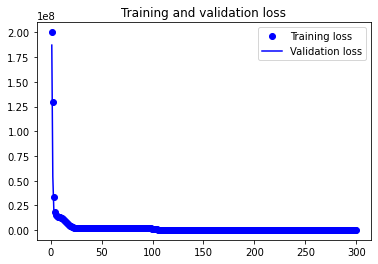

In [57]:
import matplotlib.pyplot as plt
loss = fittedModel.history['loss']
val_loss = fittedModel.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model2.save('/content/models')

In [ ]:
# model2.load_weights('/content/checkpoint_dir/checkpoint2.h5')


In [ ]:
fittedModel2 = model2.fit(y_train, y_train, batch_size = 64, epochs = 300, 
                        verbose = 2, validation_data=(y_val, y_val),callbacks=[checkpointer])

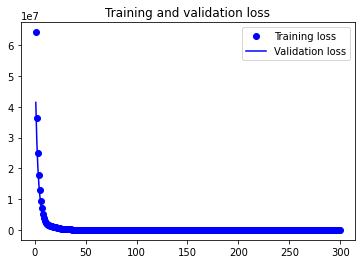

In [ ]:
import matplotlib.pyplot as plt
loss = fittedModel2.history['loss']
val_loss = fittedModel2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model2.save('/content/convauto-ecog')

Training ConvAuto with EEG as Inputs and ECOG as Labels

In [89]:
model3 = ConvAuto(Chans =  19, Samples =64, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
opt = Adam(learning_rate=1e-7)
model3.compile(loss="mse", optimizer=opt)

In [90]:
checkpointer = ModelCheckpoint(filepath='/content/checkpoint_dir/checkpointBothEEGECOG.h5', verbose=1,
                               save_best_only=True)
fittedModel3 = model2.fit(X_train, y_train, batch_size = 64, epochs = 300, 
                        verbose = 2, validation_data=(X_val, y_val),callbacks=[checkpointer])

Epoch 1/300

Epoch 1: val_loss improved from inf to 515327.96875, saving model to /content/checkpoint_dir/checkpointBothEEGECOG.h5
567/567 - 6s - loss: 600237.8125 - val_loss: 515327.9688 - 6s/epoch - 10ms/step
Epoch 2/300

Epoch 2: val_loss improved from 515327.96875 to 515129.37500, saving model to /content/checkpoint_dir/checkpointBothEEGECOG.h5
567/567 - 6s - loss: 599988.2500 - val_loss: 515129.3750 - 6s/epoch - 10ms/step
Epoch 3/300

Epoch 3: val_loss improved from 515129.37500 to 514779.96875, saving model to /content/checkpoint_dir/checkpointBothEEGECOG.h5
567/567 - 6s - loss: 599895.3750 - val_loss: 514779.9688 - 6s/epoch - 10ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 514779.96875
567/567 - 6s - loss: 599771.0000 - val_loss: 515207.3438 - 6s/epoch - 10ms/step
Epoch 5/300

Epoch 5: val_loss improved from 514779.96875 to 514721.46875, saving model to /content/checkpoint_dir/checkpointBothEEGECOG.h5
567/567 - 6s - loss: 599693.8125 - val_loss: 514721.4688 - 6s/ep

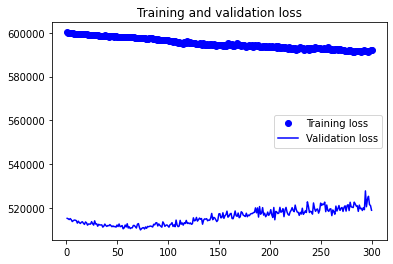

In [92]:
import matplotlib.pyplot as plt
loss = fittedModel3.history['loss']
val_loss = fittedModel3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model3.save('/content/convauto-eeg-to-ecog')

In [94]:
from tensorflow import keras


In [96]:
loadedmodel = keras.models.load_model('/content/gdrive/MyDrive/BCI_Project/ConvAuto-EEG Model/convauto-eeg')


In [98]:
pred =loadedmodel.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [101]:
X_train.shape

(36227, 19, 64, 1)

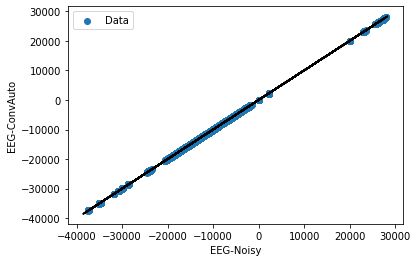

In [106]:
def plot_EEG(x, y):
  plt.scatter(np.reshape(X_test, (366*19,64)),  np.reshape(X_test,(366*19,64)), label='Data')
  plt.plot(np.reshape(pred, (366*19,64)), np.reshape(pred,(366*19,64)), color='k')
  plt.xlabel('EEG-Noisy')
  plt.ylabel('EEG-ConvAuto')
  plt.legend()
plot_EEG(X_test,pred)